In [10]:
# === 1. IMPORT LIBRARY ===
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image                                 # untuk load & save gambar
from skimage.color import rgb2lab, lab2rgb            # untuk konversi warna RGB ↔ LAB
from sklearn.model_selection import train_test_split  # untuk membagi data train/val
import cv2                                            # untuk manipulasi warna di ruang HSV

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

In [11]:
# === 2. KONFIGURASI PATH & PARAMETER ===
DATA_DIR         = "/content/dataset/input"        # folder dataset custom (warna)
OUTPUT_DIR       = "/content/output/predicted"      # folder untuk menyimpan hasil
SATURATION_BOOST = 1.3                              # faktor boost saturasi (>1 = lebih cerah)
os.makedirs(OUTPUT_DIR, exist_ok=True)              # buat folder output jika belum ada

In [12]:

# === 3. LOAD & PREPROCESS DATA ===
def load_rgb_lab(folder, img_size=(256,256), max_imgs=500):
    """
    Load gambar RGB, convert ke LAB, dan pisahkan L sebagai input,
    ab sebagai target. Normalisasi semua channel ke [0,1].
    """
    L_list, ab_list = [], []
    for i, fname in enumerate(sorted(os.listdir(folder))):
        if i >= max_imgs:
            break
        path = os.path.join(folder, fname)
        img  = Image.open(path).convert('RGB').resize(img_size)  # load & resize
        arr  = np.array(img) / 255.0                             # normalisasi [0,1]
        lab  = rgb2lab(arr).astype('float32')                    # ke LAB
        # pisahkan channel
        L    = lab[:,:,0] / 100.0                                # L → [0,1]
        ab   = (lab[:,:,1:] + 128) / 255.0                       # a,b → [0,1]
        L_list.append(L.reshape(*img_size,1))                    # shape (H,W,1)
        ab_list.append(ab)                                        # shape (H,W,2)
    return np.stack(L_list), np.stack(ab_list)                   # kembalikan array

# load dataset
x_L, y_ab = load_rgb_lab(DATA_DIR, img_size=(256,256), max_imgs=500)
print("Loaded:", x_L.shape, y_ab.shape)  # tampilkan jumlah data

# bagi data ke train & validation
x_tr, x_val, y_tr, y_val = train_test_split(
    x_L, y_ab, test_size=0.1, random_state=42)

Loaded: (50, 256, 256, 1) (50, 256, 256, 2)


In [13]:

# === 4. DEFINISI MODEL AUTOENCODER ===
inp = Input(shape=(256,256,1))                  # input adalah channel L

# --- Encoder: ekstraksi fitur & kompresi spasial
x   = Conv2D(64,   (3,3), activation='relu', padding='same')(inp)
x   = MaxPooling2D((2,2), padding='same')(x)
x   = Conv2D(128,  (3,3), activation='relu', padding='same')(x)
x   = MaxPooling2D((2,2), padding='same')(x)
x   = Conv2D(256,  (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# --- Decoder: rekonstruksi channel ab
x   = Conv2D(256,  (3,3), activation='relu', padding='same')(encoded)
x   = UpSampling2D((2,2))(x)
x   = Conv2D(128,  (3,3), activation='relu', padding='same')(x)
x   = UpSampling2D((2,2))(x)
x   = Conv2D(64,   (3,3), activation='relu', padding='same')(x)
x   = UpSampling2D((2,2))(x)
out_ab = Conv2D(2, (3,3), activation='sigmoid', padding='same')(x)  # prediksi ab

# bangun & compile model
model = Model(inp, out_ab)
model.compile(optimizer=Adam(1e-4), loss='mse')  # MSE loss untuk ab channels
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 2)    │         1,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,730 (5.07 MB)

 Trainable params: 1,329,730 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

# === 5. TRAINING ===
history = model.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),
    epochs=100,                # sesuaikan epoch untuk eksperimen
    batch_size=8,             # batch kecil untuk detail update
    shuffle=True
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 666ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0030 - val_l

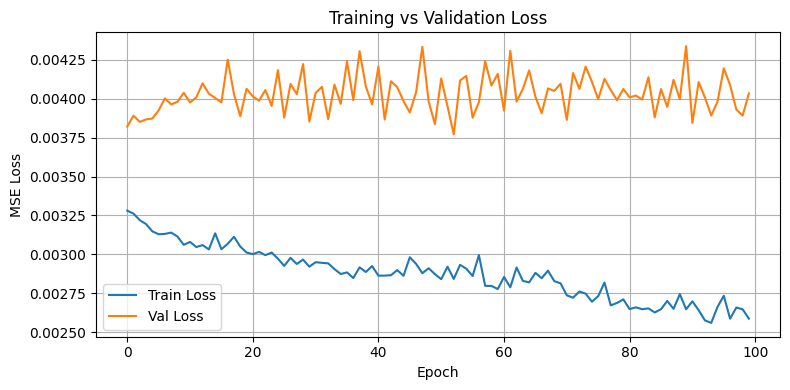

In [15]:
# === 6. VISUALISASI CURVE LOSS ===
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],   label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.legend(); plt.grid(); plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


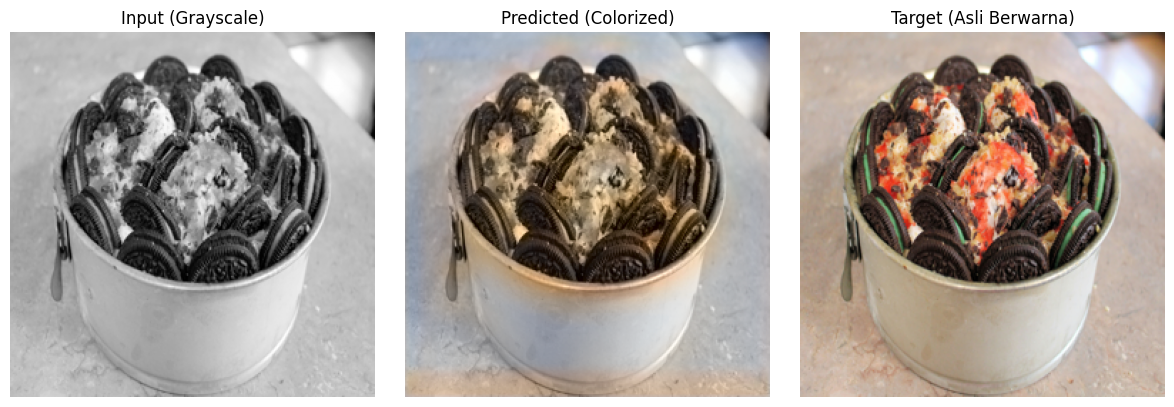

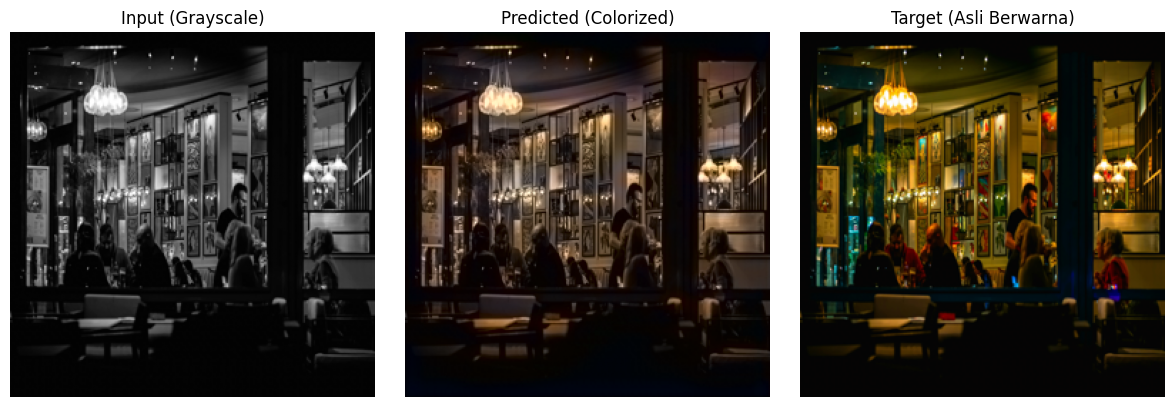

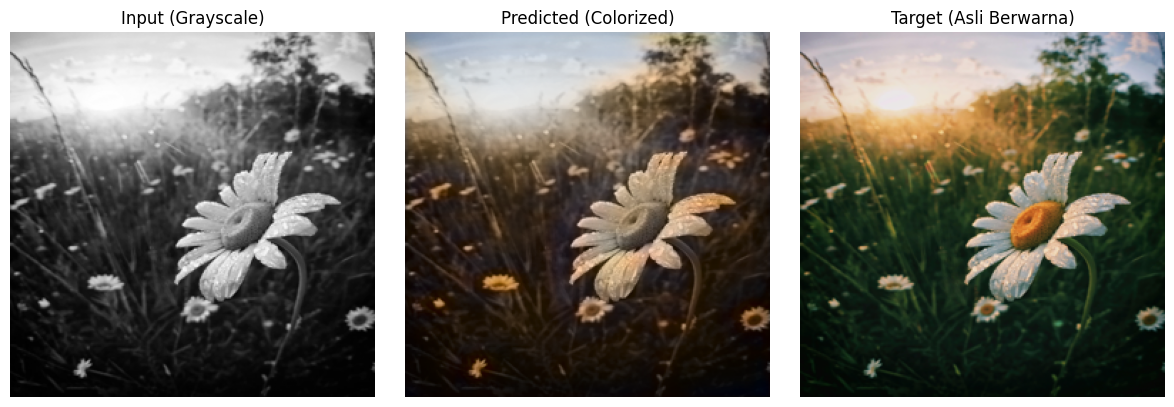

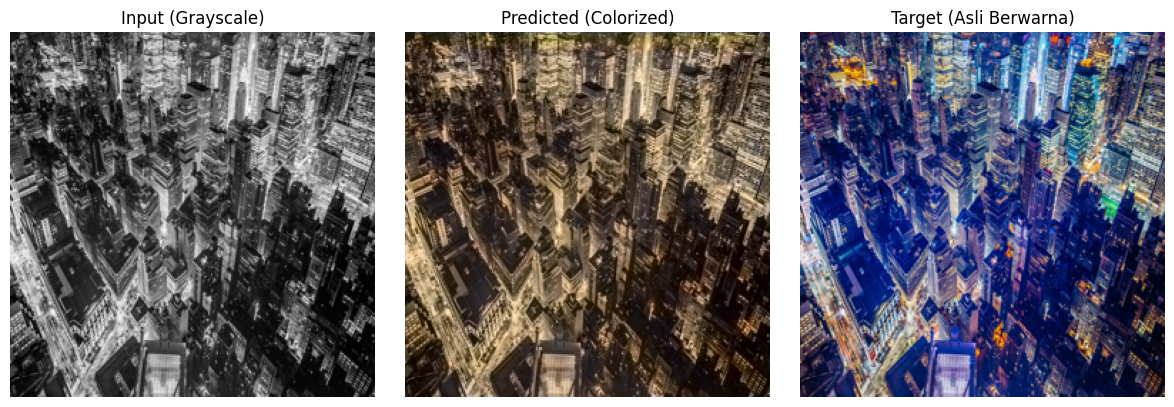

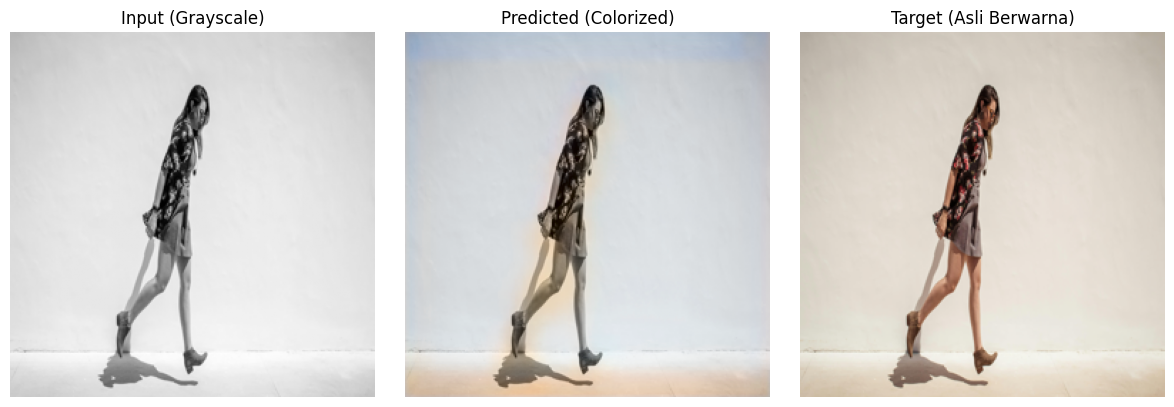

In [16]:

# === 7. PREDIKSI & TAMPILKAN HASIL ===
n_show   = min(10, len(x_val))                 # batasi maksimal tampilan
x_sample = x_val[:n_show]
y_sample = y_val[:n_show]
preds_ab = model.predict(x_sample)             # prediksi ab

def boost_saturation(rgb_img, factor=1.3):
    """
    Peningkatan saturasi di ruang HSV untuk warna lebih vivid.
    """
    img_uint8 = (rgb_img * 255).astype('uint8')
    hsv       = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[...,1] = np.clip(hsv[...,1] * factor, 0, 255)
    boosted   = cv2.cvtColor(hsv.astype('uint8'), cv2.COLOR_HSV2RGB)
    return boosted / 255.0

# loop setiap sampel dan plot 3 kolom
for i in range(n_show):
    L       = x_sample[i] * 100.0                         # kembali ke skala [0,100]
    ab_pred = preds_ab[i] * 255.0 - 128.0                  # skala [-128,127]
    lab_pred= np.concatenate([L, ab_pred], axis=-1)        # gabung L+ab
    rgb_pred= lab2rgb(lab_pred)                            # ke RGB [0,1]
    rgb_pred= boost_saturation(rgb_pred, SATURATION_BOOST) # boost saturasi

    # ground truth ab
    ab_true = y_sample[i] * 255.0 - 128.0
    lab_true= np.concatenate([L, ab_true], axis=-1)
    rgb_true= lab2rgb(lab_true)

    gray    = x_sample[i].squeeze()                        # citra grayscale

    # plotting
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    titles = ['Input (Grayscale)', 'Predicted (Colorized)', 'Target (Asli Berwarna)']
    imgs   = [gray, rgb_pred, rgb_true]
    for ax, img, title in zip(axes, imgs, titles):
        if img.ndim == 2:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# === 8. SIMPAN HASIL PREDIKSI ===
for i in range(n_show):
    L       = x_sample[i] * 100.0
    ab_pred = preds_ab[i] * 255.0 - 128.0
    lab_pred= np.concatenate([L, ab_pred], axis=-1)
    rgb_pred= boost_saturation(lab2rgb(lab_pred), SATURATION_BOOST)
    save_img= (rgb_pred * 255).astype('uint8')
    save_path= os.path.join(OUTPUT_DIR, f"predicted_boosted_{i}.png")
    Image.fromarray(save_img).save(save_path)
